## A) Blah blah

#### Colab stuff

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv

/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv


#### Libraries

In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

#### Helper functions

In [4]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

#### Data importation

In [5]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10  # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


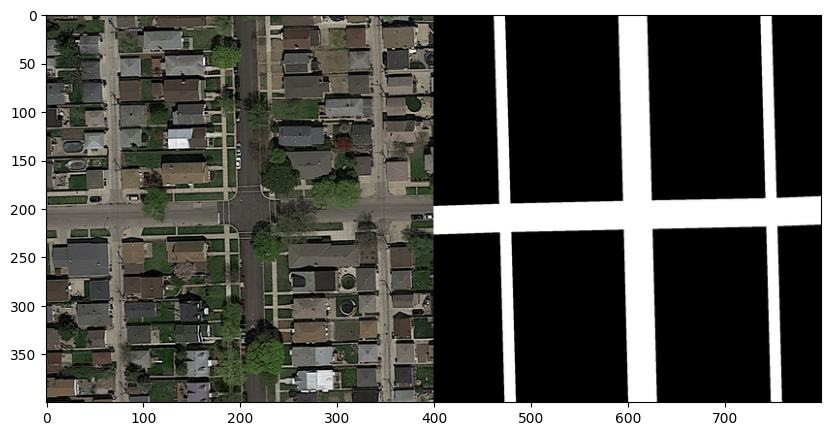

In [6]:
#Check if importation was successful
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

## B) Basic CNN for segmentation task

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the CNN architecture
class SimpleRoadSegmentationCNN(nn.Module):
    def __init__(self):
        super(SimpleRoadSegmentationCNN, self).__init__()
        # Assume the input image is single-channel (grayscale), 256x256 pixels
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # The output layer should have a single output channel, for binary classification
        self.output = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.sigmoid(self.output(x)) # Output should be the same size as the input
        return x

# Define a dataset
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = torch.load(self.image_paths[idx]) # Replace with actual loading logic
        mask = torch.load(self.mask_paths[idx]) # Replace with actual loading logic
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Define a training function
def train(model, dataloader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Assume we have a list of file paths for images and corresponding masks
image_paths = ['path/to/image1.pt', 'path/to/image2.pt']  # Dummy file paths
mask_paths = ['path/to/mask1.pt', 'path/to/mask2.pt']  # Dummy file paths

# Transform to convert images to PyTorch tensors and normalize if necessary
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transformations if needed
])

# Create the dataset and dataloader
dataset = RoadSegmentationDataset(image_paths, mask_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Create the model, criterion, and optimizer
model = SimpleRoadSegmentationCNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, dataloader, criterion, optimizer, num_epochs=5)
